In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import FOLPSD as FOLPS
!pwd

/Users/waco/Desktop/folpsD


#### Inputs

Fix *cosmological* and *nuisance parameters*. Upload the corresponding linear power spectrum. You can also compute it using an Einstein-Boltzmann code like **CAMB**, **CLASS**, etc. 

Cosmological parameters:

Define a vector with the cosmological parameters, CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]

In [4]:
#CMASS NGC cosmology

#omega_i = Omega_i h² 
omega_b = 0.02242;        #baryons
omega_cdm = 0.117;       #CDM
omega_ncdm = 0.0;    #massive neutrinos 
h = 0.67;                 #h = H0/100
z_pk = 0.57;                 #evaluation redshift
CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]


Linear power spectrum at redshift z_pk:

In [6]:
inputpkT = np.loadtxt('pk_linear_simtocmass.txt', unpack = True)

Nuisance parameters for the linear power spectrum:

Define a vector with the nuisances parameters, NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP]

In [8]:
#bias parameters
b1 = 1.9;                 
b2= 8/21*(b1-1)
bs2= -4/7*(b1-1)      
b3nl = 32/315*(b1 - 1);  

#EFT parameters
alpha0, alpha2, alpha4 = 0,0,0    # PEFT(k) = (alpha0 + alpha2*mu^2+ alpha4*mu^4)  k^2 Plin(k)
ctilde = 0               #NLO counterterm
X_FoG = 0  # uses a Lorentzian Damping 1/(1+x^2), with x = X_FoG f sigma_v mu. 

#Stochatics parameters
# Noise is Pshot = PshotP * ( alphashot0 + alphashot2*(k*mu)**2 )
alphashot0 = 0;          
alphashot2 = 0;            
PshotP = 0    # =1/barn.  Poissonian shot noise
NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP,X_FoG]

#### Computation of $M$ matrices 
**They do not depend on the cosmology**, so they are **computed only one time**. That is, the first time the code is called, it computes the $M$ matrices and stores them for the rest of the runs, which can be of the order of thousands in parameter estimations.

In [10]:
matrices = FOLPS.Matrices()

N = 128 sampling points
M matrices have been computed


In [11]:
## AP
Omfid = -1  # for AP set > 0
APtrue = False
if Omfid > 0:
    APtrue = True
    
if z_pk < 0.0000000000001:
    APtrue = False
    Omfid = -1    

In [12]:
# output k_ev
k_ev = np.logspace(np.log10(0.01), np.log10(0.3), num = 100) # array of k_ev in [h/Mpc]

In [13]:
# Compute 1loop integrals
nonlinear = FOLPS.NonLinear(inputpkT, CosmoParams)
kh, pkl0, pkl2, pkl4 = FOLPS.RSDmultipoles(k_ev, NuisanParams, Omfid = Omfid, AP=APtrue)

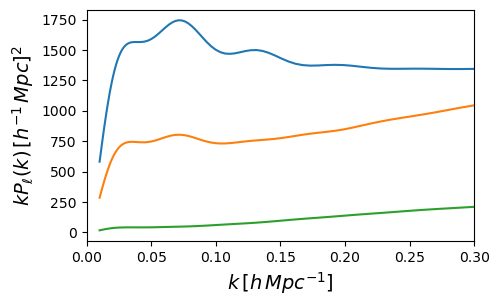

In [14]:
fig, axs = plt.subplots(figsize=(5,3))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k P_{\ell}(k) \, [h^{-1} \,  Mpc]^2$', fontsize =  14)

axs.plot(kh, kh * pkl0, label=r'$\ell = 0$')
axs.plot(kh, kh * pkl2, label=r'$\ell = 2$')
axs.plot(kh, kh * pkl4, label=r'$\ell = 4$')

axs.set_xlim([0, 0.3])
plt.show()


# Run Bispectrum in Sugiyama basis

In [16]:
# niusance parameters for the bispectrum
Pshot = 0; # This would be the same as PshopP*alphashot0 if the bispectrum were computed up to 1loop (I think!)
Bshot = 0;
c1,c2=-40,0
X_FoG_bk=0

bisp_nuis_params = [b1, b2, bs2, c1,c2,Pshot,Bshot, X_FoG_bk]
OmM=(omega_cdm+omega_b+omega_ncdm)/h**2
bisp_cosmo_params = [OmM,h]

In [17]:
k_ev = np.linspace(0.01,0.2, num = 40) 
k_ev_bk=np.vstack([k_ev,k_ev]).T   # List of pairs of k. (B=B(k1,k2))
precision=[10,10,10]

k1k2pairs=k_ev_bk

In [18]:
qpar,qperp=1,1

In [19]:
%%time
k_pkl_pklnw=np.array([nonlinear[0][0], nonlinear[0][1], nonlinear[1][1]])
qpar,qperp=1,1
B000, B110, B220, B202, B404 = FOLPS.Sugiyama_Bl1l2L(k1k2pairs, bisp_nuis_params, bisp_cosmo_params, qpar, qperp, k_pkl_pklnw, 
                     precision=[10,10,10], 
                     f=None, 
                     renormalize=True, 
                     interpolation_method='cubic')

cubic
CPU times: user 8.41 ms, sys: 1.66 ms, total: 10.1 ms
Wall time: 9.4 ms


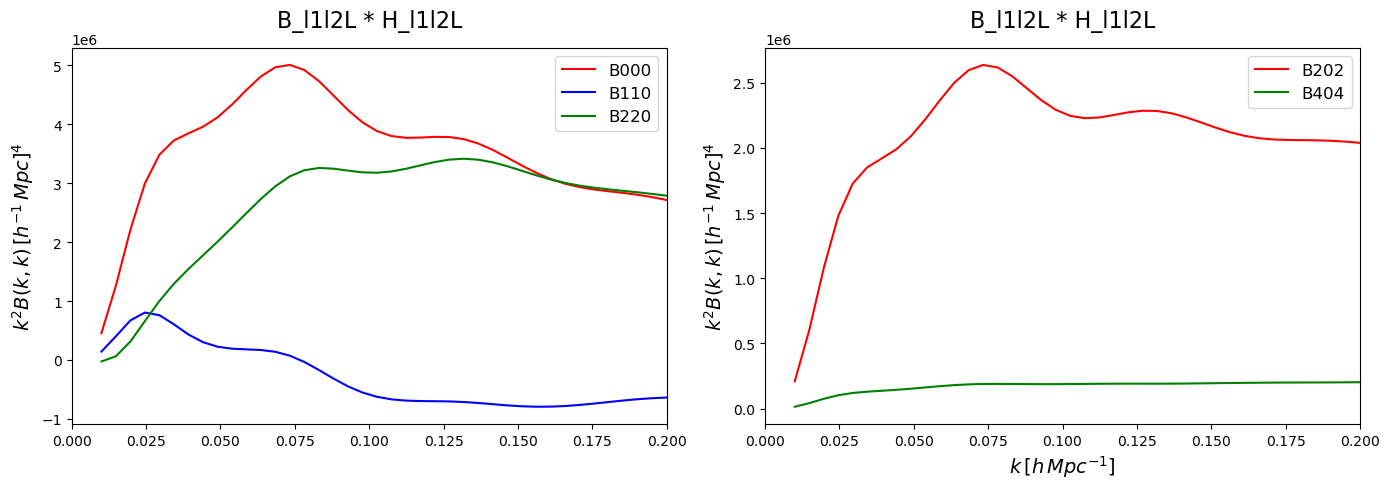

In [20]:
xmax=0.2

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
axs[0].plot(k_ev, k_ev**2 * B000, label=r'B000', ls='-', color='red')
axs[0].plot(k_ev, k_ev**2 * B110, label=r'B110', ls='-', color='blue')
axs[0].plot(k_ev, k_ev**2 * B220, label=r'B220', ls='-', color='green')
axs[0].set_xlim([0, xmax])
axs[0].legend(fontsize=12, loc='best')
axs[0].set_title('B_l1l2L * H_l1l2L', fontsize=16, pad=15)

axs[1].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize=14)
axs[1].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
axs[1].plot(k_ev, k_ev**2 * B202, label=r'B202', ls='-', color='red')
# axs[1].plot(k_ev, k_ev**2 * B112, label=r"B112==0: doesn't work", ls='--', color='blue')
axs[1].plot(k_ev, k_ev**2 * B404, label=r'B404', ls='-', color='green')
axs[1].set_xlim([0, xmax])
axs[1].legend(fontsize=12, loc='best')
axs[1].set_title('B_l1l2L * H_l1l2L', fontsize=16, pad=15)


plt.tight_layout()
plt.show()

(Note B112 is not yet implemented)

In the above plot, we are rescaling the multipoles by the factors: 

H202 =  1/np.sqrt(5)
H110 = -1/np.sqrt(3)
H220 =  1/np.sqrt(5)
H112 =  np.sqrt(2.0/15.0)
H404 =  1.0/3.0

in this way we can match Fig.3 of Sugiyama et al 1803.02132.   

We can keep the "correct" normalization factors by adding the argument renormalize=False:

cubic


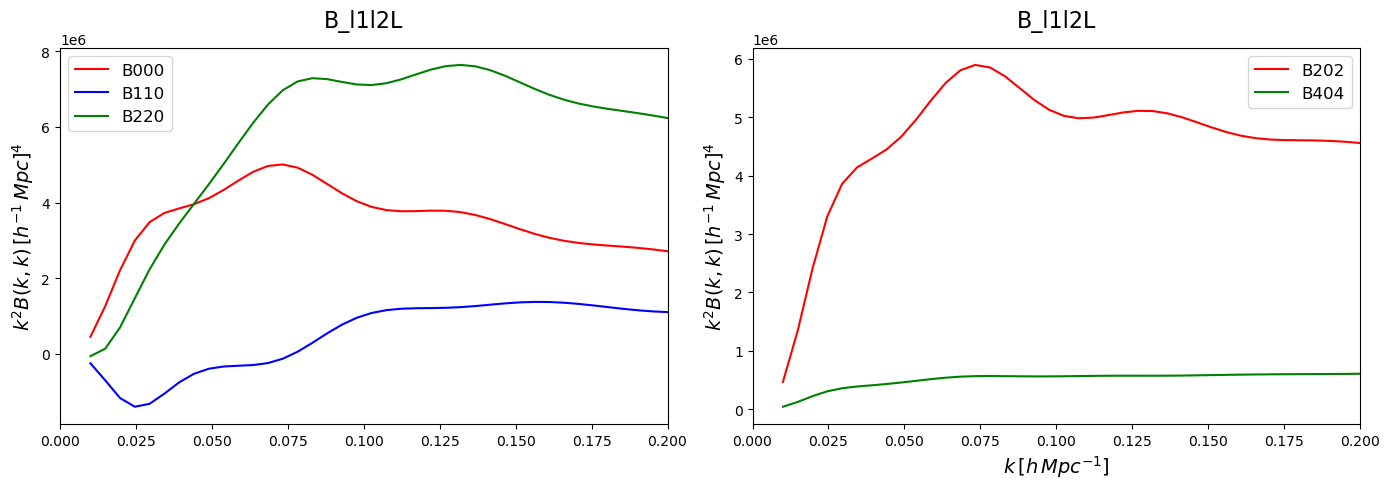

In [22]:

k_pkl_pklnw=np.array([nonlinear[0][0], nonlinear[0][1], nonlinear[1][1]])
B000_c, B110_c, B220_c, B202_c, B404_c = FOLPS.Sugiyama_Bl1l2L(k1k2pairs, bisp_nuis_params, bisp_cosmo_params, qpar, qperp, k_pkl_pklnw, 
                     precision=[10,10,10], 
                     f=None, 
                     renormalize=False, 
                     interpolation_method='cubic')

xmax=0.2

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
axs[0].plot(k_ev, k_ev**2 * B000_c, label=r'B000', ls='-', color='red')
axs[0].plot(k_ev, k_ev**2 * B110_c, label=r'B110', ls='-', color='blue')
axs[0].plot(k_ev, k_ev**2 * B220_c, label=r'B220', ls='-', color='green')
axs[0].set_xlim([0, xmax])
axs[0].legend(fontsize=12, loc='best')
axs[0].set_title('B_l1l2L', fontsize=16, pad=15)

axs[1].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize=14)
axs[1].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
axs[1].plot(k_ev, k_ev**2 * B202_c, label=r'B202', ls='-', color='red')
# axs[1].plot(k_ev, k_ev**2 * B112_c, label=r"B112==0: doesn't work", ls='--', color='blue')
axs[1].plot(k_ev, k_ev**2 * B404_c, label=r'B404', ls='-', color='green')
axs[1].set_xlim([0, xmax])
axs[1].legend(fontsize=12, loc='best')
axs[1].set_title('B_l1l2L', fontsize=16, pad=15)


plt.tight_layout()
plt.show()

### precision  [Nphi,Nx,Nmu]

In [24]:
%%time
## The precision can be changed at the cost of being slower. 
precision_l=[8,10,10]
B000, B110, B220, B202, B404 = FOLPS.Sugiyama_Bl1l2L(k1k2pairs, bisp_nuis_params, bisp_cosmo_params, qpar, qperp, k_pkl_pklnw, 
                     precision=precision_l,#[15,15,15], 
                     f=None, 
                     renormalize=True, 
                     interpolation_method='cubic')

cubic
CPU times: user 7.14 ms, sys: 1.68 ms, total: 8.83 ms
Wall time: 8.04 ms


In [25]:
%%time
## The precision can be changed at the cost of being slower. 
precision_m=[32,32,32]
B000_mp, B110_mp, B220_mp, B202_mp, B404_mp = FOLPS.Sugiyama_Bl1l2L(k1k2pairs, bisp_nuis_params, bisp_cosmo_params, qpar, qperp, k_pkl_pklnw, 
                     precision=precision_m,#[15,15,15], 
                     f=None, 
                     renormalize=True, 
                     interpolation_method='cubic')

cubic
CPU times: user 199 ms, sys: 35.6 ms, total: 235 ms
Wall time: 234 ms


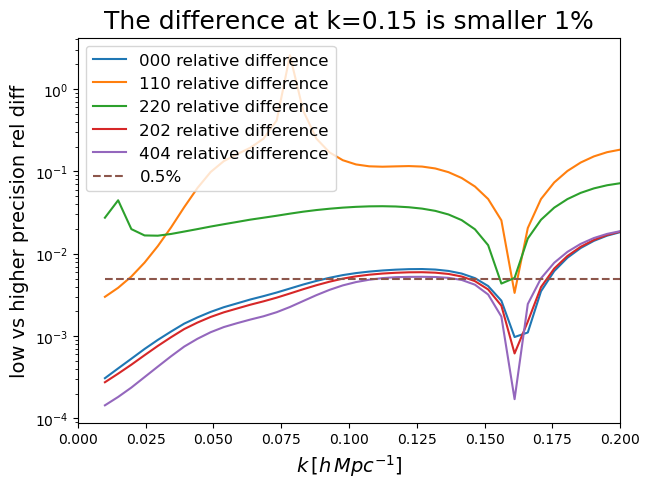

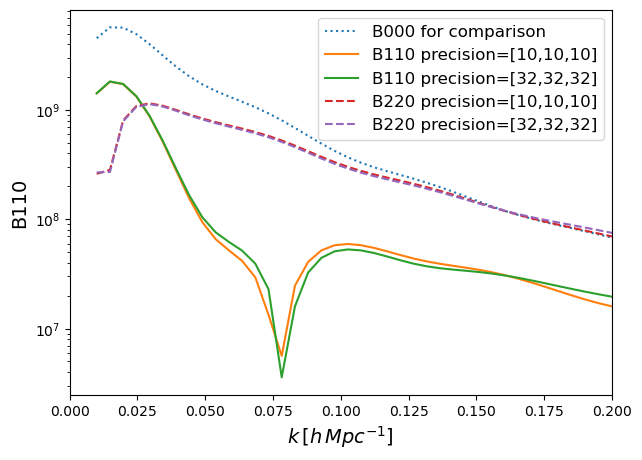

In [26]:



fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'low vs higher precision rel diff', fontsize =  14)

axs.semilogy(k_ev, np.abs(1-B000/B000_mp), label=r'000 relative difference')
axs.semilogy(k_ev, np.abs(1-B110/B110_mp), label=r'110 relative difference')
axs.semilogy(k_ev, np.abs(1-B220/B220_mp), label=r'220 relative difference')
axs.semilogy(k_ev, np.abs(1-B202/B202_mp), label=r'202 relative difference')
axs.semilogy(k_ev, np.abs(1-B404/B404_mp), label=r'404 relative difference')

axs.semilogy(k_ev, 0.005*np.ones(len(k_ev)), ls='--', label=r'0.5%')

axs.legend(fontsize=12, loc='best')
axs.set_title('The difference at k=0.15 is smaller 1%', fontsize=18, pad=7)

axs.set_xlim([0, 0.20])
plt.show()



fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'B110', fontsize =  14)

axs.semilogy(k_ev, np.abs(B000)   , ls=':', label=r'B000 for comparison')

axs.semilogy(k_ev, np.abs(B110)   , label=r'B110 precision=[10,10,10]')
axs.semilogy(k_ev, np.abs(B110_mp), label=r'B110 precision=[32,32,32]')
axs.semilogy(k_ev, np.abs(B220)   , ls='--',  label=r'B220 precision=[10,10,10]')
axs.semilogy(k_ev, np.abs(B220_mp), ls='--', label=r'B220 precision=[32,32,32]')
# axs.plot(k_ev, np.zeros(len(k_ev)), ls='--')

axs.legend(fontsize=12, loc='best')




axs.set_xlim([0, 0.20])
plt.show()




## precision  cubic vs linear interpolation

linear interpolation is much faster

In [28]:
%%time
B000_l, B110_l, B220_l, B202_l, B404_l = FOLPS.Sugiyama_Bl1l2L(k1k2pairs, bisp_nuis_params, bisp_cosmo_params, qpar, qperp, k_pkl_pklnw, 
                     precision=[8,10,10], 
                     f=None, 
                     renormalize=True, 
                     interpolation_method='linear') 

linear
CPU times: user 5.2 ms, sys: 1.9 ms, total: 7.1 ms
Wall time: 6.37 ms


In [29]:
%%time
B000, B110, B220, B202, B404 = FOLPS.Sugiyama_Bl1l2L(k1k2pairs, bisp_nuis_params, bisp_cosmo_params, qpar, qperp, k_pkl_pklnw, 
                     precision=[8,10,10], 
                     f=None, 
                     renormalize=True, 
                     interpolation_method='cubic')

cubic
CPU times: user 7.24 ms, sys: 1.52 ms, total: 8.76 ms
Wall time: 8.01 ms


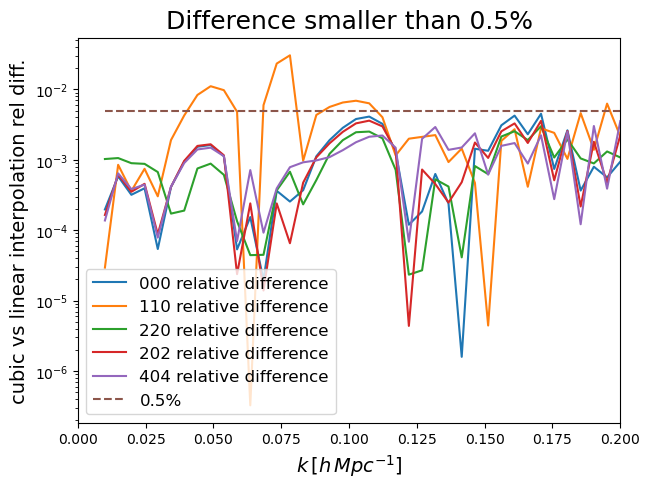

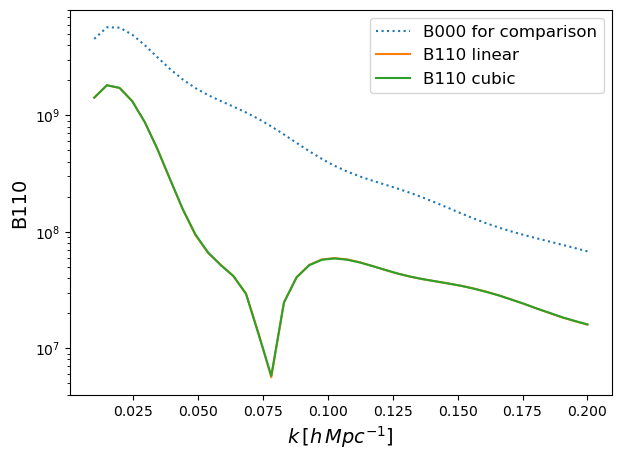

In [30]:



fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'cubic vs linear interpolation rel diff.', fontsize =  14)

axs.semilogy(k_ev, np.abs(1-B000/B000_l), label=r'000 relative difference')
axs.semilogy(k_ev, np.abs(1-B110/B110_l), label=r'110 relative difference')
axs.semilogy(k_ev, np.abs(1-B220/B220_l), label=r'220 relative difference')
axs.semilogy(k_ev, np.abs(1-B202/B202_l), label=r'202 relative difference')
axs.semilogy(k_ev, np.abs(1-B404/B404_l), label=r'404 relative difference')

axs.semilogy(k_ev, 0.005*np.ones(len(k_ev)), ls='--', label=r'0.5%')

axs.legend(fontsize=12, loc='best')
axs.set_title('Difference smaller than 0.5%', fontsize=18, pad=7)

axs.set_xlim([0, 0.20])
plt.show()



fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'B110', fontsize =  14)

axs.semilogy(k_ev, np.abs(B000)   , ls=':', label=r'B000 for comparison')

axs.semilogy(k_ev, np.abs(B110)   , label=r'B110 linear')
axs.semilogy(k_ev, np.abs(B110_l), label=r'B110 cubic')
# axs.plot(k_ev, np.zeros(len(k_ev)), ls='--')

axs.legend(fontsize=12, loc='best')




# axs.set_xlim([0, 0.20])
# plt.show()




## 2Dimensions precision  highest vs fastest

In [32]:
k_ev = np.linspace(0.01, 0.18, num=18)

K1, K2 = np.meshgrid(k_ev, k_ev)    # each is (40,40)
pairs = np.column_stack([K1.ravel(), K2.ravel()])

print(pairs.shape)
k1k2pairs=pairs

(324, 2)


In [33]:
%%time
# fastest
B000_f, B110_f, B220_f, B202_f, B404_f = FOLPS.Sugiyama_Bl1l2L(k1k2pairs, bisp_nuis_params, bisp_cosmo_params, qpar, qperp, k_pkl_pklnw, 
                     precision=[8,10,10], 
                     f=None, 
                     renormalize=True, 
                     interpolation_method='linear') 

linear
CPU times: user 23.7 ms, sys: 6.5 ms, total: 30.2 ms
Wall time: 29.6 ms


In [34]:
%%time
B000_m, B110_m, B220_m, B202_m, B404_m = FOLPS.Sugiyama_Bl1l2L(k1k2pairs, bisp_nuis_params, bisp_cosmo_params, qpar, qperp, k_pkl_pklnw, 
                     precision=[15,15,15], 
                     f=None, 
                     renormalize=True, 
                     interpolation_method='linear') 

linear
CPU times: user 96.3 ms, sys: 29.6 ms, total: 126 ms
Wall time: 125 ms


In [35]:
%%time
B000_h, B110_h, B220_h, B202_h, B404_h = FOLPS.Sugiyama_Bl1l2L(k1k2pairs, bisp_nuis_params, bisp_cosmo_params, qpar, qperp, k_pkl_pklnw, 
                     precision=[32,32,32], 
                     f=None, 
                     renormalize=True, 
                     interpolation_method='cubic') 

cubic
CPU times: user 1.69 s, sys: 388 ms, total: 2.08 s
Wall time: 2.09 s


In [36]:
k1_vals = np.unique(k1k2pairs[:,0])
k2_vals = np.unique(k1k2pairs[:,1])

Nk1 = len(k1_vals)
Nk2 = len(k2_vals)

# reshape outputs to 2D matrices
B000_d_f = B000_f.reshape(Nk1, Nk2).diagonal()
B110_d_f = B110_f.reshape(Nk1, Nk2).diagonal()
B220_d_f = B220_f.reshape(Nk1, Nk2).diagonal()
B202_d_f = B202_f.reshape(Nk1, Nk2).diagonal()
B404_d_f = B404_f.reshape(Nk1, Nk2).diagonal()


# reshape outputs to 2D matrices
B000_d_m = B000_m.reshape(Nk1, Nk2).diagonal()
B110_d_m = B110_m.reshape(Nk1, Nk2).diagonal()
B220_d_m = B220_m.reshape(Nk1, Nk2).diagonal()
B202_d_m = B202_m.reshape(Nk1, Nk2).diagonal()
B404_d_m = B404_m.reshape(Nk1, Nk2).diagonal()


# reshape outputs to 2D matrices
B000_d_h = B000_h.reshape(Nk1, Nk2).diagonal()
B110_d_h = B110_h.reshape(Nk1, Nk2).diagonal()
B220_d_h = B220_h.reshape(Nk1, Nk2).diagonal()
B202_d_h = B202_h.reshape(Nk1, Nk2).diagonal()
B404_d_h = B404_h.reshape(Nk1, Nk2).diagonal()

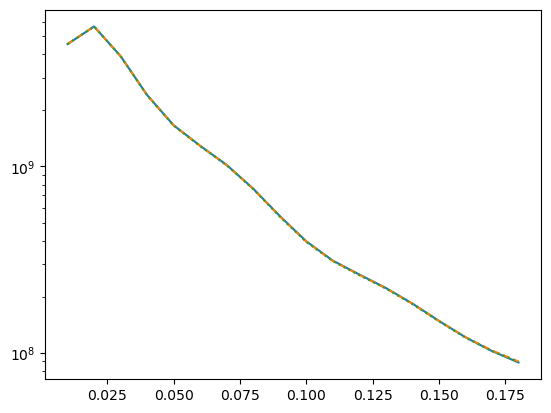

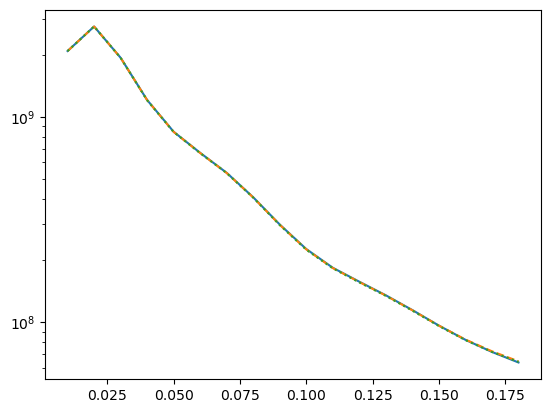

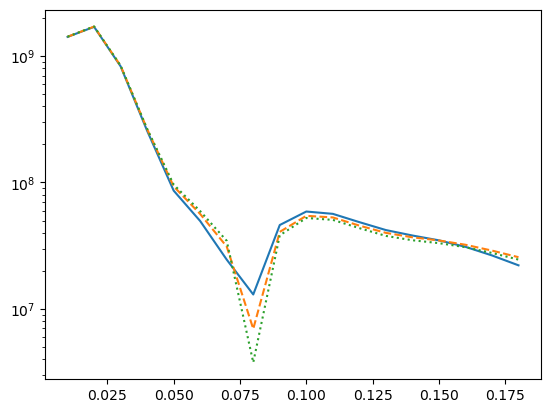

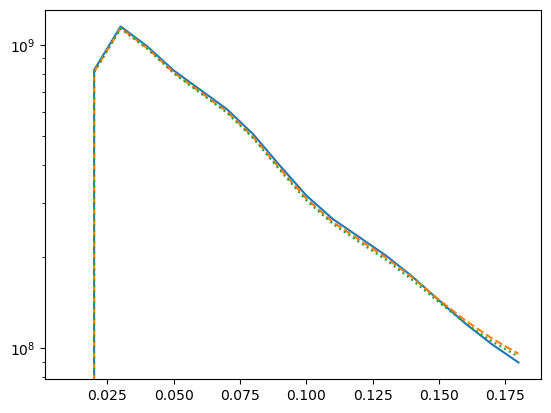

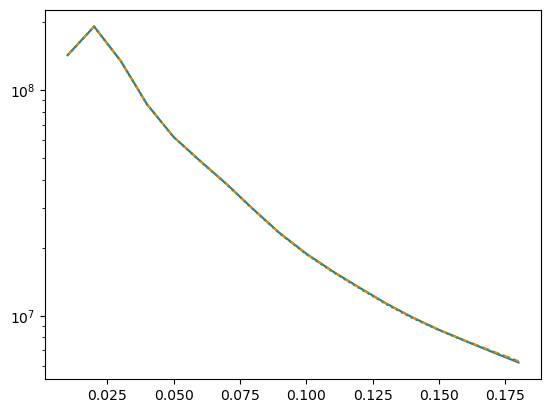

In [37]:
plt.semilogy(k_ev, B000_d_f )
plt.semilogy(k_ev, B000_d_m, ls='--')
plt.semilogy(k_ev, B000_d_h, ls=':')
plt.show()

plt.semilogy(k_ev, B202_d_f )
plt.semilogy(k_ev, B202_d_m, ls='--')
plt.semilogy(k_ev, B202_d_h, ls=':')
plt.show()

plt.semilogy(k_ev, np.abs(B110_d_f) )
plt.semilogy(k_ev, np.abs(B110_d_m), ls='--')
plt.semilogy(k_ev, np.abs(B110_d_h), ls=':')
plt.show()

plt.semilogy(k_ev, B220_d_f )
plt.semilogy(k_ev, B220_d_m, ls='--')
plt.semilogy(k_ev, B220_d_h, ls=':')
plt.show()


plt.semilogy(k_ev, B404_d_f )
plt.semilogy(k_ev, B404_d_m, ls='--')
plt.semilogy(k_ev, B404_d_h, ls=':')
plt.show()

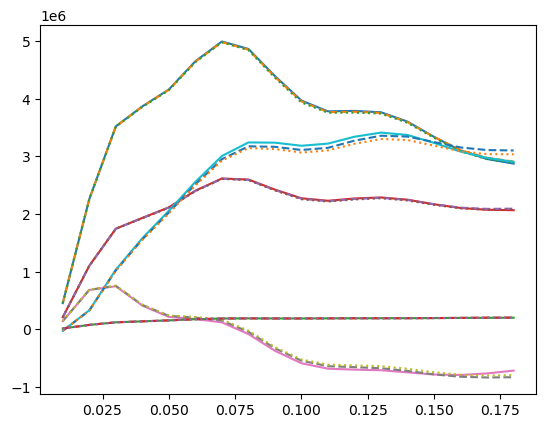

In [38]:
plt.plot(k_ev,k_ev**2*B000_d_f )
plt.plot(k_ev,k_ev**2*B000_d_m, ls='--')
plt.plot(k_ev,k_ev**2*B000_d_h, ls=':')


plt.plot(k_ev,k_ev**2*B202_d_f )
plt.plot(k_ev,k_ev**2*B202_d_m, ls='--')
plt.plot(k_ev,k_ev**2*B202_d_h, ls=':')


plt.plot(k_ev,k_ev**2*B110_d_f )
plt.plot(k_ev,k_ev**2*B110_d_m, ls='--')
plt.plot(k_ev,k_ev**2*B110_d_h, ls=':')


plt.plot(k_ev,k_ev**2*B220_d_f )
plt.plot(k_ev,k_ev**2*B220_d_m, ls='--')
plt.plot(k_ev,k_ev**2*B220_d_h, ls=':')



plt.plot(k_ev,k_ev**2*B404_d_f )
plt.plot(k_ev,k_ev**2*B404_d_m, ls='--')
plt.plot(k_ev,k_ev**2*B404_d_h, ls=':')
plt.show()

# Plot 2D multipoles

In [40]:
renormalize=True
k_ev = np.linspace(0.01, 0.30, num=30)

K1, K2 = np.meshgrid(k_ev, k_ev)    # each is (40,40)
pairs = np.column_stack([K1.ravel(), K2.ravel()])

print(pairs.shape)
k1k2pairs=pairs

(900, 2)


In [41]:
%%time
B000_2, B110_2, B220_2, B202_2, B404_2 = FOLPS.Sugiyama_Bl1l2L(k1k2pairs, bisp_nuis_params, bisp_cosmo_params, 
                                                               qpar, qperp, k_pkl_pklnw, 
                     precision=[8,10,10], 
                     f=None, 
                     renormalize=True, 
                     interpolation_method='linear')

linear
CPU times: user 64.8 ms, sys: 18.4 ms, total: 83.2 ms
Wall time: 82.7 ms


In [42]:
B000_2.shape

(900,)

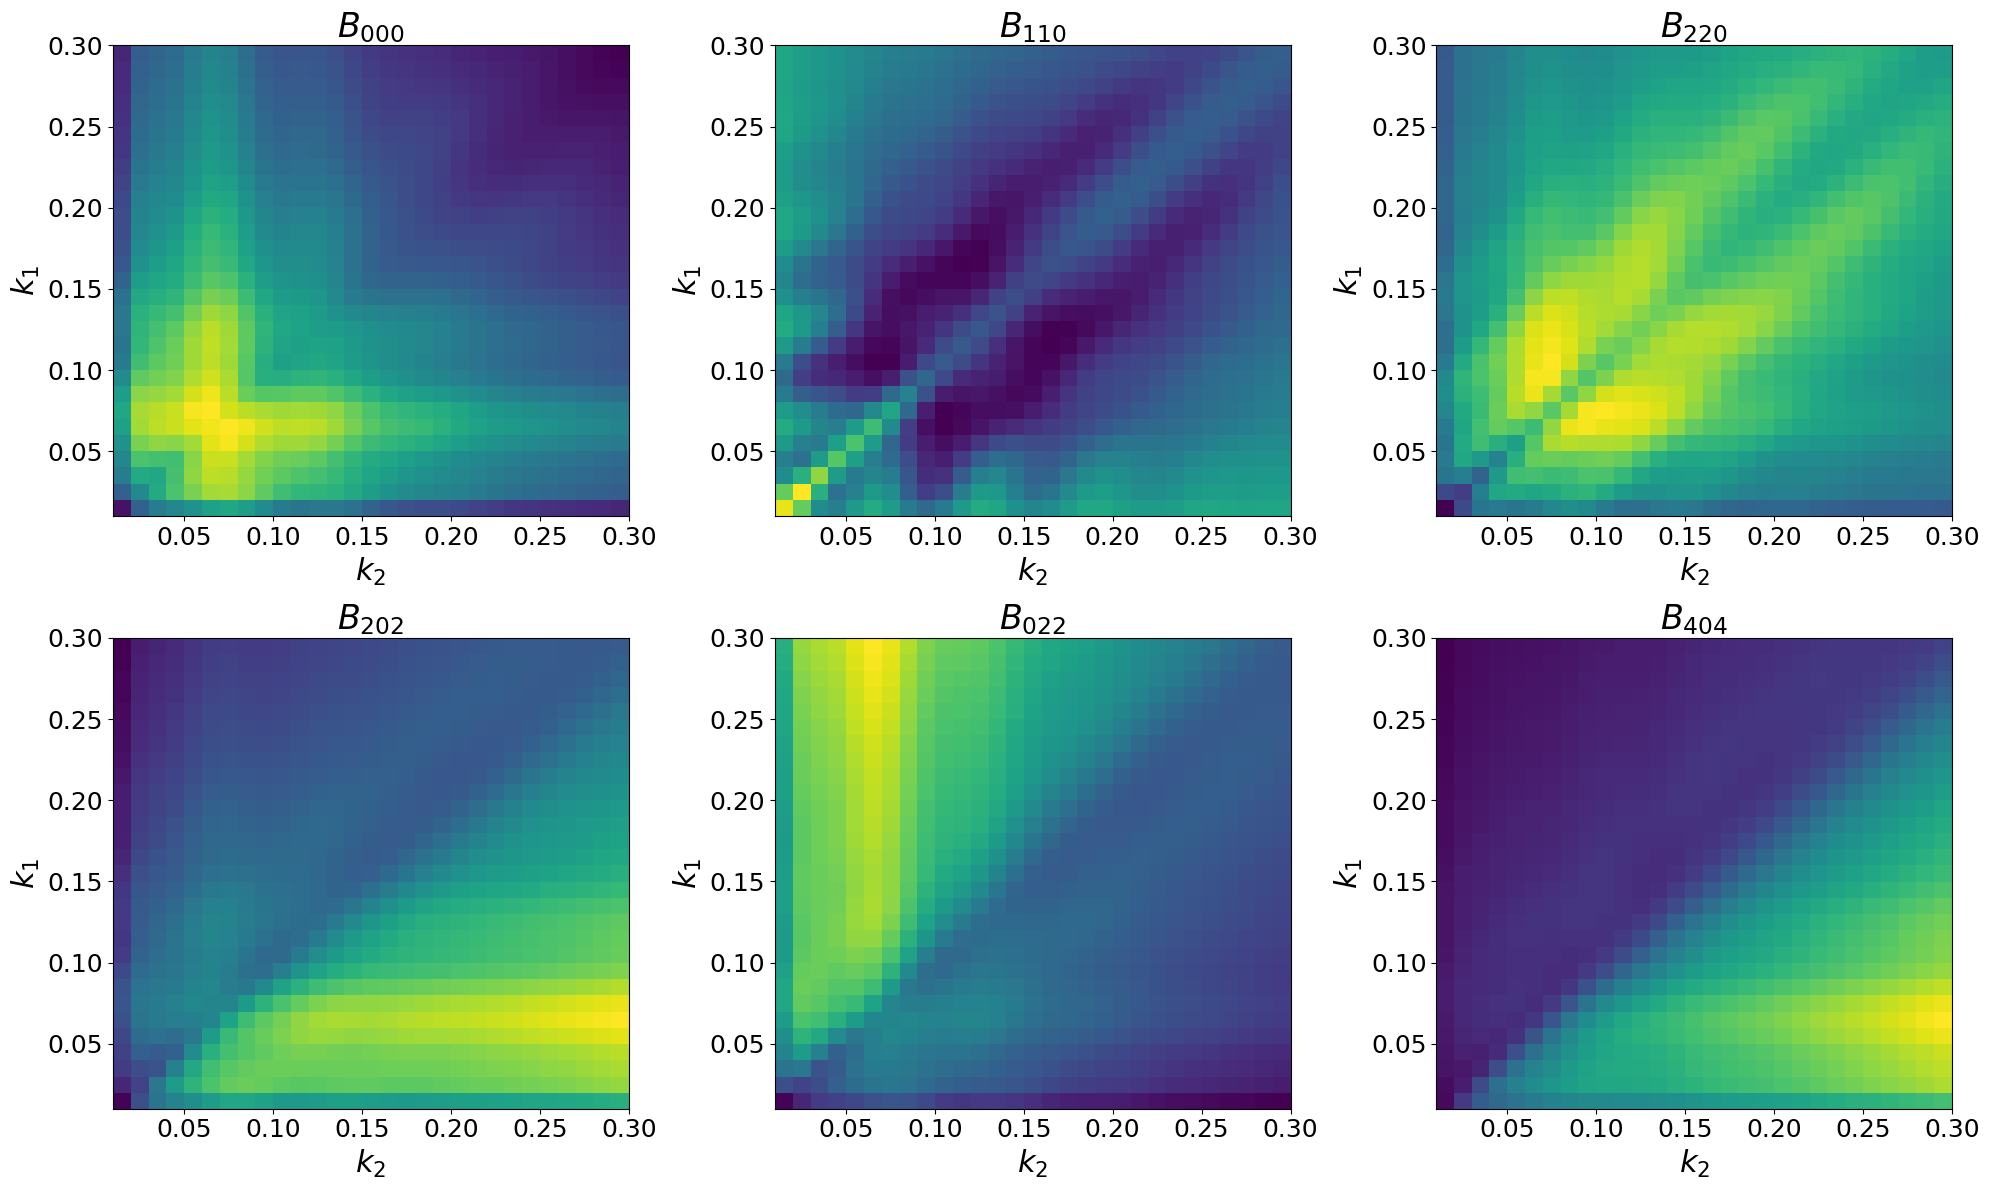

In [43]:
# k1k2pairs is N×2
k1_vals = np.unique(k1k2pairs[:,0])
k2_vals = np.unique(k1k2pairs[:,1])

Nk1 = len(k1_vals)
Nk2 = len(k2_vals)

# reshape outputs to 2D matrices
B000_grid = B000_2.reshape(Nk1, Nk2)
B110_grid = B110_2.reshape(Nk1, Nk2)
B220_grid = B220_2.reshape(Nk1, Nk2)
B202_grid = B202_2.reshape(Nk1, Nk2)
B022_grid = B202_grid.T
B404_grid = B404_2.reshape(Nk1, Nk2)

B000_scaled = B000_grid * k2_vals[:, None] * k1_vals[None, :]
B110_scaled = B110_grid * k2_vals[:, None] * k1_vals[None, :]
B220_scaled = B220_grid * k2_vals[:, None] * k1_vals[None, :]
B202_scaled = B202_grid * k2_vals[:, None] * k1_vals[None, :]
B022_scaled = B022_grid * k1_vals[:, None] * k2_vals[None, :]
B404_scaled = B404_grid * k2_vals[:, None] * k1_vals[None, :]

fig, axes = plt.subplots(2, 3, figsize=(20,12))

fs=24
fsk=22
fsl=18
showbar=False
# B000 imshow
im0 = axes[0,0].imshow(B000_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[0,0].set_title(r"$B_{000}$", fontsize=fs)
axes[0,0].set_xlabel("$k_2$", fontsize=fsk)
axes[0,0].set_ylabel("$k_1$", fontsize=fsk)
axes[0,0].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im0, ax=axes[0,0])

# B110 imshow
im1 = axes[0,1].imshow(B110_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[0,1].set_title(r"$B_{110}$", fontsize=fs)
axes[0,1].set_xlabel("$k_2$", fontsize=fsk)
axes[0,1].set_ylabel("$k_1$", fontsize=fsk)
axes[0,1].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im1, ax=axes[0,1])


# B110 imshow
im2 = axes[0,2].imshow(B220_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[0,2].set_title(r"$B_{220}$", fontsize=fs)
axes[0,2].set_xlabel("$k_2$", fontsize=fsk)
axes[0,2].set_ylabel("$k_1$", fontsize=fsk)
axes[0,2].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im3, ax=axes[0,2])

# B110 imshow
im2 = axes[1,0].imshow(B202_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[1,0].set_title(r"$B_{202}$", fontsize=fs)
axes[1,0].set_xlabel("$k_2$", fontsize=fsk)
axes[1,0].set_ylabel("$k_1$", fontsize=fsk)
axes[1,0].tick_params(axis='both', which='major', labelsize=fsl)

axes[1,0].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im2, ax=axes[1,0])





im3 = axes[1,1].imshow(B022_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[1,1].set_title(r"$B_{022}$", fontsize=fs)
axes[1,1].set_xlabel("$k_2$", fontsize=fsk)
axes[1,1].set_ylabel("$k_1$", fontsize=fsk)

axes[1,1].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im3, ax=axes[1,1])






im3 = axes[1,2].imshow(B404_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[1,2].set_title(r"$B_{404}$", fontsize=fs)
axes[1,2].set_xlabel("$k_2$", fontsize=fsk)
axes[1,2].set_ylabel("$k_1$", fontsize=fsk)
axes[1,2].tick_params(axis='both', which='major', labelsize=fsl)

if showbar:
    fig.colorbar(im3, ax=axes[1,2])



plt.tight_layout()
plt.show()